# SARIMAX

### IMPORTS

In [30]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import sqrt
from scipy import stats
from sklearn.metrics import mean_squared_error
from datetime import datetime

### CARGA DE COMPLETE RETURNS Y RENTALS

In [2]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_LOG1P_EXOGVAR.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_LOG1P_EXOGVAR.csv')

In [54]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_EXOGVAR.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_EXOGVAR.csv')

In [55]:
dates = pd.to_datetime(completeReturnsDf['Date'])
completeRentalsDf.set_index('Date', inplace=True)
completeReturnsDf.set_index('Date', inplace=True)
completeRentalsDf['Date'] = completeReturnsDf['Date']= pd.to_datetime(completeRentalsDf.index.values)

### SARIMAX

In [56]:
EXOGENOUS_VARIABLES = ['31201_lag24', '31201_lag48', '31201_lag168', 'temp', 'humidity', 'Hour']

In [57]:
train = completeRentalsDf[ (completeRentalsDf['Date'] >= datetime(2010, 9, 27)) & (completeRentalsDf['Date'] < datetime(2021, 9, 9))]
validation = completeRentalsDf[ (completeRentalsDf['Date'] >= datetime(2021, 9, 9)) & (completeRentalsDf['Date'] < datetime(2021, 12, 20))]
test = completeRentalsDf[ (completeRentalsDf['Date'] >= datetime(2021, 12, 20)) & (completeRentalsDf['Date'] <= datetime(2022, 3, 31))]

exogTrain = train.loc[:, completeRentalsDf.columns.isin(EXOGENOUS_VARIABLES)].values
train = train['31201']
trainHistory = [x for x in train]

exogValidation = validation.loc[:, completeRentalsDf.columns.isin(EXOGENOUS_VARIABLES)]
exogTest = test.loc[:, completeRentalsDf.columns.isin(EXOGENOUS_VARIABLES)].values

In [58]:
p = 1
d = 0
q = 1
P = 1
D = 0
Q = 1

In [59]:
model= sm.tsa.statespace.SARIMAX(trainHistory, exog=exogTrain, order=(p, d, q),seasonal_order=(P, D, Q,24)).fit(disp=False)

In [60]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                96000
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -239296.635
Date:                            Thu, 16 Jun 2022   AIC                         478615.271
Time:                                    18:08:42   BIC                         478719.464
Sample:                                         0   HQIC                        478646.949
                                          - 96000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5988      0.007     89.884      0.000       0.586       0.612
x2             0.0675      0.005   

In [61]:
residuals = pd.Series(model.resid[25:])
print("Student's criterion: p=%f" % stats.ttest_1samp(model.resid[25:], 0)[1])
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(residuals)[1])

Student's criterion: p=0.005294
Dickey-Fuller criterion: p=0.000000


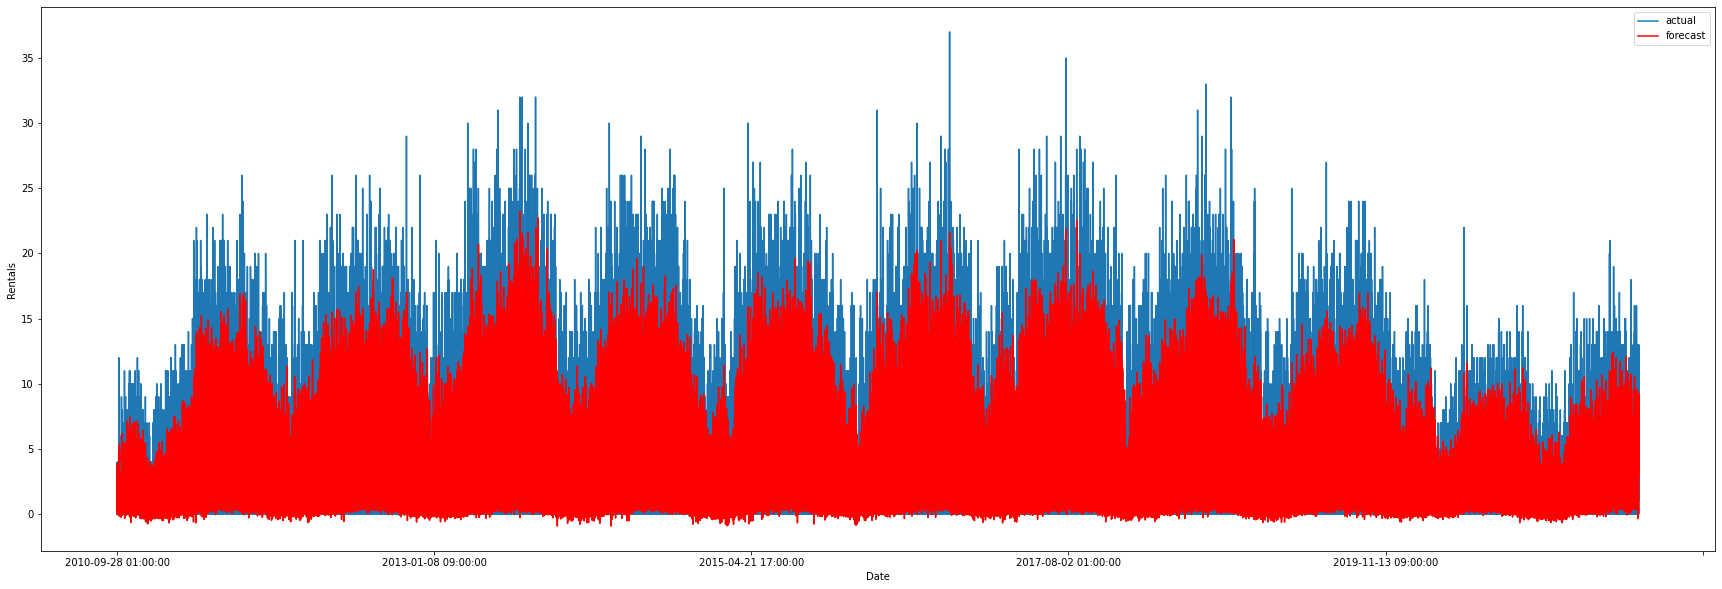

In [62]:
plt.figure(figsize=(30, 10))
df_indices_list = train.index.values
df_model = pd.DataFrame()
df_model.index = df_indices_list[25:]
df_model['fitted_values'] = model.fittedvalues[25:]

train[25:].plot(label='actual')
df_model['fitted_values'].plot(color='r', label='forecast')

plt.ylabel('Rentals')
plt.legend();

In [63]:
predictions = model.predict(exog=exogValidation, start = 0, end = len(exogValidation)-1)
print("VALIDATION RMSE: {}".format(sqrt(mean_squared_error(validation['31201'][25:], predictions[25:]))))

VALIDATION RMSE: 3.86669091566745


TEST RMSE: 2.555884823382067


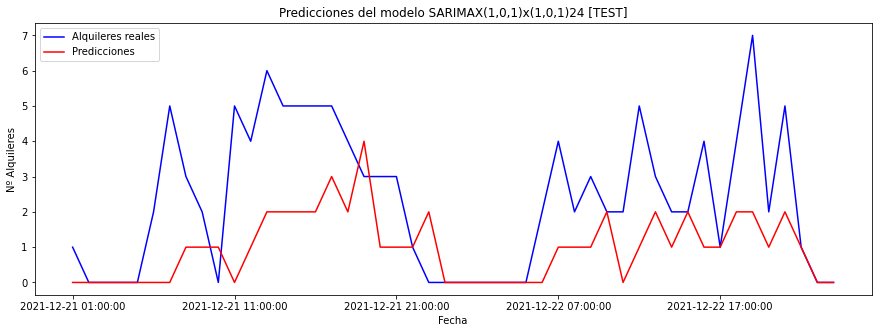

In [69]:
plt.figure(figsize=(15, 5))
predictions = model.predict(exog=exogTest, start = 0, end = len(exogTest)-1)

print("TEST RMSE: {}".format(sqrt(mean_squared_error(test['31201'][25:], predictions[25:]))))

test['predictions'] = np.round(predictions)
test['31201'][25:73].plot(color='b', label='Alquileres reales')
test['predictions'][25:73].plot(color='r', label='Predicciones')


plt.ylabel('Nº Alquileres')
plt.xlabel('Fecha')
plt.title('Predicciones del modelo SARIMAX(1,0,1)x(1,0,1)24 [TEST]')
plt.legend()